In [2]:
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results

Random Seed:  999


In [4]:
# Root directory for dataset
dataroot = "data"

# Number of workers for dataloader
workers = 0

# Batch size during training
batch_size = 50

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 50

# Size of feature maps in generator
ngf = 10

# Size of feature maps in discriminator
ndf = 10

# Number of training epochs
num_epochs = 30

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 0

In [5]:
class Dataset():
    def __init__(self, root = dataroot):
        self.root = root
        self.dataset = self.build_dataset()
        self.length = self.dataset.shape[1]

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        step = self.dataset[:, idx]
        target = 0  # only one class
        return step#, target

    def build_dataset(self):
        dataset = np.load(os.path.join(self.root, "round1.npy")).T
        dataset = torch.from_numpy(dataset).float()
        dataset = torch.unsqueeze(dataset, -1)
        return dataset

In [6]:
dataset = Dataset(dataroot)

In [7]:
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [8]:
next(iter(iter(dataloader)))[0]

tensor([[6.0700],
        [9.0900],
        [7.5900],
        [2.4500]])

In [9]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        n = m.in_features
        y = 1.0/np.sqrt(n)
        # nn.init.normal_(m.weight.data, 0.0, y)
        nn.init.uniform_(m.weight.data, -y, y)
        # nn.init.normal_(m.weight.data, 0.0, 1e-2)

In [10]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z
            nn.Linear(nz, ngf * 8, bias=False),
            nn.ReLU(True),
            # state size. ``(ngf*8)``
            nn.Linear(ngf * 8, ngf * 4, bias=False),
            nn.ReLU(True),
            # state size. ``(ngf*4)``
            nn.Linear(ngf * 4, ngf * 2, bias=False),
            nn.ReLU(True),
            # state size. ``(ngf*2)``
            nn.Linear(ngf * 2, ngf, bias=False),
            nn.ReLU(True),
            # state size. ``(ngf)``
            nn.Linear(ngf, nc, bias=False),
            nn.ReLU(True)
            # state size. ``(nc)``
        )

    def forward(self, input):
        return self.main(input)

In [11]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): Linear(in_features=50, out_features=80, bias=False)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=80, out_features=40, bias=False)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=40, out_features=20, bias=False)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=20, out_features=10, bias=False)
    (7): ReLU(inplace=True)
    (8): Linear(in_features=10, out_features=1, bias=False)
    (9): ReLU(inplace=True)
  )
)


In [12]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc)``
            nn.Linear(in_features=nc, out_features=ndf, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf)``
            nn.Linear(ndf, ndf * 2, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2)``
            nn.Linear(ndf * 2, ndf * 4, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4)``
            nn.Linear(ndf * 4, ndf * 8, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8)``
            nn.Linear(ndf * 8, 1, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [13]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Linear(in_features=1, out_features=10, bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=10, out_features=20, bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Linear(in_features=20, out_features=40, bias=False)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Linear(in_features=40, out_features=80, bias=False)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=80, out_features=1, bias=False)
    (9): Sigmoid()
  )
)


In [14]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(1, nz, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [15]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/30][0/23]	Loss_D: 1.3230	Loss_G: 0.6931	D(x): 0.5327	D(G(z)): 0.5000 / 0.5000
[1/30][0/23]	Loss_D: 1.1907	Loss_G: 0.6915	D(x): 0.6118	D(G(z)): 0.5008 / 0.5008
[2/30][0/23]	Loss_D: 1.0841	Loss_G: 0.6861	D(x): 0.6854	D(G(z)): 0.5035 / 0.5036
[3/30][0/23]	Loss_D: 0.9190	Loss_G: 0.6663	D(x): 0.8213	D(G(z)): 0.5134 / 0.5136
[4/30][0/23]	Loss_D: 0.8086	Loss_G: 0.6240	D(x): 0.9597	D(G(z)): 0.5356 / 0.5359
[5/30][0/23]	Loss_D: 1.0629	Loss_G: 0.5236	D(x): 0.8553	D(G(z)): 0.5926 / 0.5926
[6/30][0/23]	Loss_D: 1.2412	Loss_G: 0.4252	D(x): 0.8515	D(G(z)): 0.6564 / 0.6544
[7/30][0/23]	Loss_D: 1.1885	Loss_G: 0.4836	D(x): 0.8030	D(G(z)): 0.6176 / 0.6166
[8/30][0/23]	Loss_D: 1.2661	Loss_G: 0.4777	D(x): 0.7524	D(G(z)): 0.6222 / 0.6205
[9/30][0/23]	Loss_D: 1.3611	Loss_G: 0.4833	D(x): 0.6774	D(G(z)): 0.6187 / 0.6170
[10/30][0/23]	Loss_D: 1.4501	Loss_G: 0.4829	D(x): 0.6191	D(G(z)): 0.6206 / 0.6171
[11/30][0/23]	Loss_D: 1.3392	Loss_G: 0.5849	D(x): 0.5927	D(G(z)): 0.5572 / 0.5572


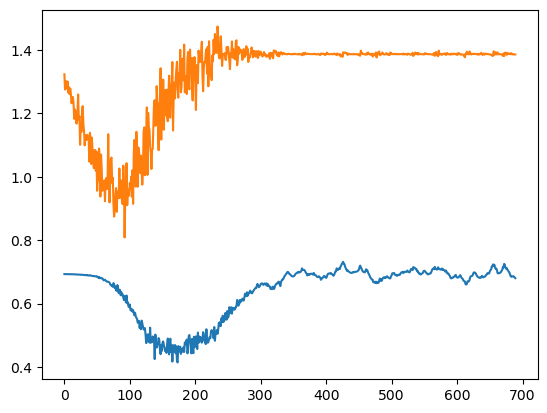

In [16]:
plt.plot(G_losses)
plt.plot(D_losses)

## Test distance de Wasserstein

In [17]:
from DWasserstein4D import dWasserstein4D

In [18]:
n = 100
x = np.random.randn(n, 4)
y = np.random.randn(n, 4)

In [19]:
dWasserstein4D(x, y, 100), dWasserstein4D(x,y,1000), dWasserstein4D(x, y, 10000)

(0.20493599864125223, 0.1998423894065218, 0.19969312233379438)

## Génération de données

In [20]:
data = np.load("data/round1.npy")
N = data.shape[0]

In [21]:
genData = np.empty((N, 4))
for i in range(N):
    noise = torch.randn(b_size, nz, device=device)
    fake = netG(noise)
    genData[i,:] = fake.detach().numpy().T[0]

In [22]:
dWasserstein4D(data, genData, niter = int(1e4))

2.0641811718855605

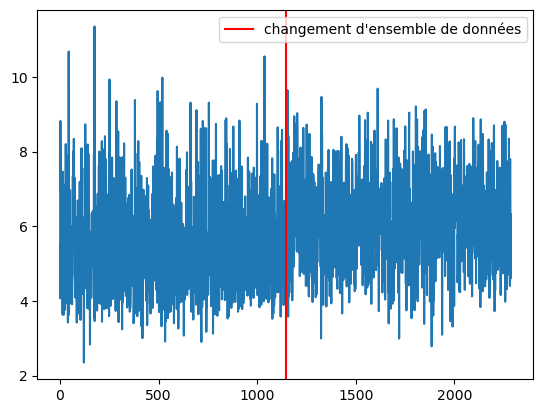

In [34]:
for i in range(1):
    plt.plot(np.concatenate((data[:,i], genData[:,i])), alpha = 1)
    # plt.plot(genData[:,i], alpha = 0.5)
plt.axvline(x=1144, color = "red", label = "changement d'ensemble de données")
plt.legend()

In [24]:
genData

array([[4.98489285, 8.27910233, 5.27769518, 7.08056355],
       [6.42524338, 5.04363489, 5.9915123 , 6.23349667],
       [4.10744715, 6.08483887, 7.28128624, 5.27855301],
       ...,
       [4.59586382, 5.06052494, 6.0932045 , 5.7791853 ],
       [6.33014584, 5.99575901, 7.47542381, 5.4151845 ],
       [5.80834579, 6.16410971, 6.94005442, 6.35902596]])

In [25]:
# np.save("generated_data/genDataSoline", genData)